In [1]:
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.001

log_interval = 10

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=False)

torch.Size([1000, 1, 28, 28])


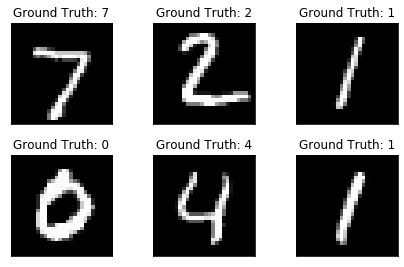

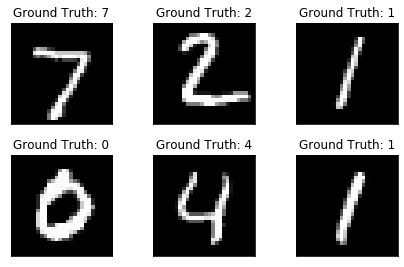

In [2]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)

import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [5]:
class Net(nn.Module):
    def __init__(self, size=10):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, size)
        self.fc2 = nn.Linear(size, 10)

    def forward(self, x):
        assert x.shape[1:] == torch.Size((1, 28, 28))
        b = x.shape[0]
        x = x.view(b, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
def train_test(size=10, epochs=20, step=5, weight_decay=0.0001):
    network = Net(size=size)
    network_loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        network.parameters(), 
        lr=learning_rate,
        weight_decay=weight_decay)
    
    def train():
      network.train()
      train_loss = 0
      correct = 0
      for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = network_loss(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()

      train_loss /= len(train_loader.dataset)
      print('\nTrain set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))       

    def test():
      network.eval()
      test_loss = 0
      correct = 0
      with torch.no_grad():
        for data, target in test_loader:
          output = network(data)
          test_loss += network_loss(output, target).item()
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).sum()
      test_loss /= len(test_loader.dataset)
      print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
          
    test()
    for epoch in range(1, epochs + 1):
      train()
      test()       
      if epoch % step == 0:
        weights = {x: y.cpu().numpy() for x,y in network.state_dict().items()} 
        with open(f"weights/{size}_{epoch}_{weight_decay}.pkl", "wb") as file:
            pkl.dump(weights, file)

In [7]:
for size in range(5, 30, 5):
    print(f"Size: {size}")
    train_test(size=size, epochs=40, step=10, weight_decay=0.0001)

Size: 5

Test set: Avg. loss: 0.0023, Accuracy: 1449/10000 (14%)


Train set: Avg. loss: 0.0127, Accuracy: 44708/60000 (75%)


Test set: Avg. loss: 0.0005, Accuracy: 8477/10000 (85%)


Train set: Avg. loss: 0.0082, Accuracy: 50947/60000 (85%)


Test set: Avg. loss: 0.0005, Accuracy: 8606/10000 (86%)


Train set: Avg. loss: 0.0077, Accuracy: 51582/60000 (86%)


Test set: Avg. loss: 0.0005, Accuracy: 8678/10000 (87%)


Train set: Avg. loss: 0.0072, Accuracy: 52041/60000 (87%)


Test set: Avg. loss: 0.0004, Accuracy: 8724/10000 (87%)


Train set: Avg. loss: 0.0068, Accuracy: 52412/60000 (87%)


Test set: Avg. loss: 0.0004, Accuracy: 8753/10000 (88%)


Train set: Avg. loss: 0.0066, Accuracy: 52666/60000 (88%)


Test set: Avg. loss: 0.0004, Accuracy: 8790/10000 (88%)


Train set: Avg. loss: 0.0064, Accuracy: 52916/60000 (88%)


Test set: Avg. loss: 0.0004, Accuracy: 8823/10000 (88%)


Train set: Avg. loss: 0.0063, Accuracy: 53058/60000 (88%)


Test set: Avg. loss: 0.0004, Accuracy: 8854/100